In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, roc_auc_score
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

%matplotlib inline

In [57]:
df = pd.read_csv('../data/preprocessed_data.csv')

In [58]:
#df_with_names = pd.read_csv('../data/data_filled_nans.csv')

#### Drop Draw Rows

In [59]:
df.dropna(subset=['Winner'], inplace=True)

In [60]:
df.head()

,Winner,title_bout,B_avg_KD,B_avg_opp_KD,B_avg_SIG_STR_pct,B_avg_opp_SIG_STR_pct,B_avg_TD_pct,B_avg_opp_TD_pct,B_avg_SUB_ATT,B_avg_opp_SUB_ATT,...,B_Stance_Open Stance,B_Stance_Orthodox,B_Stance_Sideways,B_Stance_Southpaw,B_Stance_Switch,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Sideways,R_Stance_Southpaw,R_Stance_Switch
0,Red,False,0.102539,0.765625,0.455488,0.564932,0.152441,0.290742,0.756836,0.000000,...,0,1,0,0,0,0,1,0,0,0
1,Red,False,0.258088,0.062996,0.574714,0.458967,0.330410,0.183517,0.109620,0.502482,...,0,0,0,1,0,0,1,0,0,0
2,Red,False,0.000000,0.500000,0.495000,0.500000,0.000000,0.305000,0.000000,0.000000,...,0,1,0,0,0,0,1,0,0,0
3,Red,False,0.625000,0.000000,0.529687,0.460938,0.740938,0.312500,2.156250,0.562500,...,0,1,0,0,0,0,1,0,0,0
4,Red,False,0.314453,0.125000,0.444473,0.486660,0.268789,0.628281,0.640625,1.064453,...,0,1,0,0,0,0,1,0,0,0


### Normalizing data

In [61]:
df_num = df.select_dtypes(np.number)

In [62]:
scaler = StandardScaler()

df[list(df_num.columns)] = scaler.fit_transform(df[list(df_num.columns)])

In [63]:
with open('../data/standard.scaler', 'wb') as f:
    pickle.dump(scaler, f)

### Making target variable balanced

In [9]:
df['Winner'].value_counts()

Red     4698
Blue    2454
Name: Winner, dtype: int64

In [64]:
sample = df[df['Winner']=='Red'].sample(n=949)
df.drop(sample.index, inplace=True)

In [65]:
rename_cols = {}
for column in sample.columns:
    if column.startswith('B_'):
        rename_cols['B_' + column.split('B_', 1)[1]] = 'R_' + column.split('B_', 1)[1]
        rename_cols['R_' + column.split('B_', 1)[1]] = 'B_' + column.split('B_', 1)[1]

sample.rename(rename_cols, axis='columns', inplace=True)
sample.replace({'Winner': 'Red'}, 'Blue', inplace=True)

In [66]:
df = pd.concat([df, sample]).sort_index()

### Shuffling data

In [67]:
sample1 = df[df['Winner']=='Red'].sample(n=1283)
sample2 = df[df['Winner']=='Blue'].sample(n=1283)

df.drop(sample1.index, inplace=True)
df.drop(sample2.index, inplace=True)

In [68]:
rename_cols = {}
for column in sample.columns:
    if column.startswith('B_'):
        rename_cols['B_' + column.split('B_', 1)[1]] = 'R_' + column.split('B_', 1)[1]
        rename_cols['R_' + column.split('B_', 1)[1]] = 'B_' + column.split('B_', 1)[1]

sample1.rename(rename_cols, axis='columns', inplace=True)
sample2.rename(rename_cols, axis='columns', inplace=True)

In [69]:
sample1.replace({'Winner': 'Red'}, 'Blue', inplace=True)
sample2.replace({'Winner': 'Blue'}, 'Red', inplace=True)

In [70]:
df = pd.concat([df, sample1, sample2]).sort_index()

### Splitting into train, test

In [18]:
y = df['Winner']
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
label_encoded_y = label_encoder.transform(y)
# y_test = label_encoder.transform(Test['Winner'])

X = df.drop(columns='Winner')
# X_test = Test.drop(columns='Winner')
# X_test = X_test[X.columns]

X_train, X_valid, y_train, y_valid = train_test_split(X, label_encoded_y, test_size=0.1, random_state=41)

### Fitting baseline Xgboost

In [19]:
def plot_confusion(cm, classes):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')
    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [20]:
def modelfit(alg, X_train, y_train, X_valid, y_valid, X_test=None, y_test=None,
             useTrainCV=False, test_set=False, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train, label=y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
        print(f"Best number of estimators = {cvresult.shape[0]}")
    
    #Fit the algorithm on the data
    alg.fit(np.array(X_train), np.array(y_train), eval_metric='auc')
    
    #Predict train set:
    dtrain_predictions = alg.predict(np.array(X_train))
    dtrain_predprob = alg.predict_proba(np.array(X_train))[:,1]
        
    #Predict valid set:
    dvalid_predictions = alg.predict(np.array(X_valid))
    dvalid_predprob = alg.predict_proba(np.array(X_valid))[:,1]
    
    #Predict test set:
    dtest_predictions = None
    if test_set:
        dtest_predictions = alg.predict(np.array(X_test))
        dtest_predprob = alg.predict_proba(np.array(X_test))[:,1]
        
    #Print model report:
    print("\nModel Report: ")
    if useTrainCV:
        print(f"AUC Score (Train): {roc_auc_score(y_train, dtrain_predprob)}")
    print(f"Accuracy (valid): {accuracy_score(y_valid, dvalid_predictions):.4f}")
    print(f"AUC Score (valid): {roc_auc_score(y_valid, dvalid_predprob):.4f}")
    if test_set:
        print(f"Accuracy (Test): {accuracy_score(y_test, dtest_predictions):.4f}")
        print(f"AUC Score (Test): {roc_auc_score(y_test, dtest_predprob):.4f}")
    
    
    return dvalid_predictions, dtest_predictions

/Users/philipplangfeldt/miniforge3/envs/iron_hack/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



Model Report: 
Accuracy (valid): 0.6369
AUC Score (valid): 0.6955


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

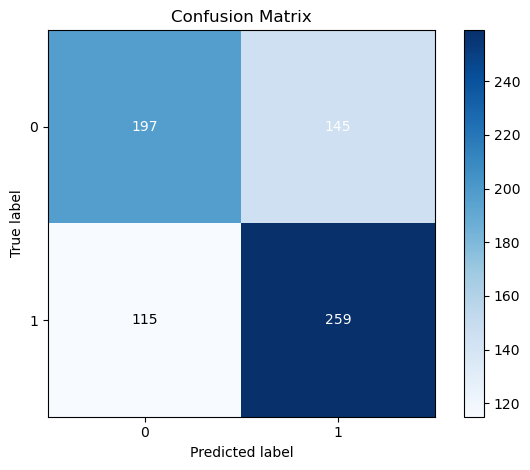

In [21]:
model1 = XGBClassifier(random_state=43, n_jobs=-1)

y1_valid_preds, y1_test_preds = modelfit(model1, X_train, y_train, X_valid, y_valid)

cm_valid = confusion_matrix(y_valid, y1_valid_preds)
# cm_test = confusion_matrix(y_test, y1_test_preds)
classes = unique_labels(y_valid, y1_valid_preds)

plot_confusion(cm_valid, classes)

In [22]:
feat_imps = {}
for i, imp in enumerate(model1.feature_importances_):
    feat_imps[X_train.columns[i]] = imp

sorted_imp_feats = (sorted(feat_imps.items(), key = lambda x: x[1], reverse=True))
sorted_imp_feats

[('R_Stance_Sideways', 0.52555686),
 ('B_win_by_Decision_Majority', 0.04599345),
 ('R_win_by_Decision_Split', 0.018157499),
 ('B_win_by_Decision_Split', 0.005782431),
 ('R_avg_opp_HEAD_landed', 0.005205152),
 ('B_avg_SIG_STR_landed', 0.0050297007),
 ('weight_class_OpenWeight', 0.0047482406),
 ('B_age', 0.004747171),
 ('R_win_by_TKO_Doctor_Stoppage', 0.0045316094),
 ('R_age', 0.0043871417),
 ('B_avg_GROUND_landed', 0.0043485705),
 ('B_avg_opp_DISTANCE_landed', 0.0043283156),
 ('B_Stance_Southpaw', 0.004071611),
 ('R_avg_opp_SIG_STR_pct', 0.004063913),
 ('R_losses', 0.004027291),
 ('B_losses', 0.004023686),
 ('B_win_by_Decision_Unanimous', 0.0039805644),
 ('B_Stance_Orthodox', 0.0038652194),
 ('B_avg_opp_GROUND_att', 0.003848942),
 ('R_Stance_Switch', 0.0037751377),
 ('R_avg_opp_DISTANCE_att', 0.0037703586),
 ('weight_class_Lightweight', 0.0037305097),
 ('B_Weight_lbs', 0.0037258947),
 ('weight_class_Bantamweight', 0.003712727),
 ('B_win_by_TKO_Doctor_Stoppage', 0.003636503),
 ('R_avg_SI

### Hyperparameter tuning 

/Users/philipplangfeldt/miniforge3/envs/iron_hack/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



Model Report: 
Accuracy (valid): 0.6676
AUC Score (valid): 0.7228


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

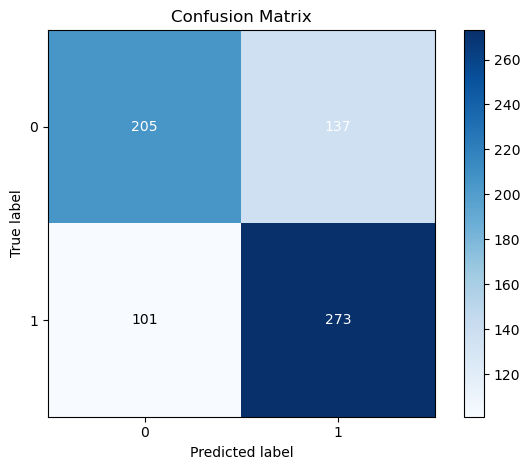

In [23]:
model3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4
#  scale_pos_weight=0.5,
)

y3_valid_preds, y3_test_preds = modelfit(model3, X_train, y_train, X_valid, y_valid)

cm_valid = confusion_matrix(y_valid, y3_valid_preds)
# cm_test = confusion_matrix(y_test, y3_test_preds)
classes = unique_labels(y_valid, y3_valid_preds)

plot_confusion(cm_valid, classes)

/Users/philipplangfeldt/miniforge3/envs/iron_hack/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



Model Report: 
Accuracy (valid): 0.6648
AUC Score (valid): 0.7361


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

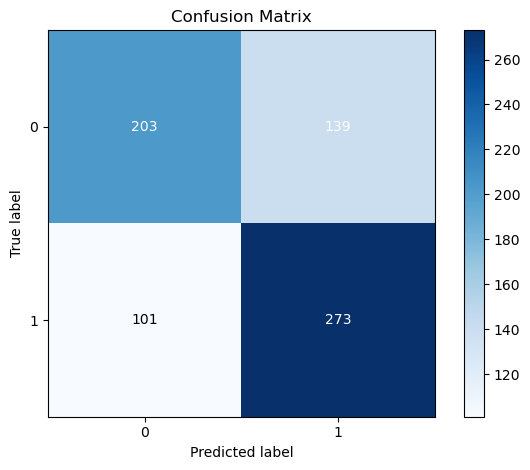

In [24]:
model5 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=120,
 max_depth=3,
 min_child_weight=1,
 gamma=0.3,
 subsample=1,
 colsample_bytree=1,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
)

y5_valid_preds, y5_test_preds = modelfit(model5, X_train, y_train, X_valid, y_valid)

cm_valid = confusion_matrix(y_valid, y5_valid_preds)
# cm_test = confusion_matrix(y_test, y5_test_preds)
classes = unique_labels(y_valid, y5_valid_preds)

plot_confusion(cm_valid, classes)

In [25]:
print(classification_report(y_valid, y1_valid_preds))

              precision    recall  f1-score   support

           0       0.63      0.58      0.60       342
           1       0.64      0.69      0.67       374

    accuracy                           0.64       716
   macro avg       0.64      0.63      0.63       716
weighted avg       0.64      0.64      0.64       716



In [26]:
print(classification_report(y_valid, y3_valid_preds))

              precision    recall  f1-score   support

           0       0.67      0.60      0.63       342
           1       0.67      0.73      0.70       374

    accuracy                           0.67       716
   macro avg       0.67      0.66      0.66       716
weighted avg       0.67      0.67      0.67       716



In [27]:
print(classification_report(y_valid, y5_valid_preds))

              precision    recall  f1-score   support

           0       0.67      0.59      0.63       342
           1       0.66      0.73      0.69       374

    accuracy                           0.66       716
   macro avg       0.67      0.66      0.66       716
weighted avg       0.67      0.66      0.66       716



In [28]:
model = model3

model.fit(np.array(X), np.array(label_encoded_y))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, nthread=4, num_parallel_tree=None,
              predictor=None, ...)

In [29]:
with open('../data/xgboost_reshuffled.pkl', 'wb') as f:
    pickle.dump(model, f)

In [30]:
with open('../data/xgboost_reshuffled.pkl', 'rb') as f:
    mdl = pickle.load(f)

In [31]:
mdl.predict(np.array(X[:40]))

array([1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1])

## Winning probability from the model for betting algorithm

In [32]:
probs = model5.predict_proba(X)

In [33]:
df_test = pd.DataFrame(y)

In [34]:
df_test['label'] = label_encoded_y

In [35]:
df_test

,Winner,label
0,Red,1
1,Red,1
2,Red,1
3,Red,1
4,Red,1
...,...,...
7149,Red,1
7150,Red,1
7151,Red,1
7152,Red,1


In [36]:
model5.classes_

array([0, 1])

In [37]:
df_probs = pd.DataFrame(probs)

In [38]:
df_probs

,0,1
0,0.280829,0.719171
1,0.556441,0.443559
2,0.362213,0.637787
3,0.366935,0.633065
4,0.387949,0.612051
...,...,...
7147,0.231432,0.768568
7148,0.273546,0.726454
7149,0.224731,0.775269
7150,0.204518,0.795482


In [39]:
df_probs.columns = ['B_win_prob', 'R_win_prob']

In [40]:
df_probs

,B_win_prob,R_win_prob
0,0.280829,0.719171
1,0.556441,0.443559
2,0.362213,0.637787
3,0.366935,0.633065
4,0.387949,0.612051
...,...,...
7147,0.231432,0.768568
7148,0.273546,0.726454
7149,0.224731,0.775269
7150,0.204518,0.795482


In [54]:
#df_probs.to_csv('../data/win_probs.csv')

In [47]:
df_raw = pd.read_csv('../data/data.csv')

In [48]:
df_probs_names = pd.concat([df_probs, df_raw], axis=1)

In [49]:
column_list = list(df_probs_names.columns)
column_list.remove('B_win_prob')
column_list.remove('R_win_prob')
column_list.remove('date')
column_list.remove('R_fighter')
column_list.remove('B_fighter')

In [50]:
df_probs_names.drop(columns=column_list, inplace=True)

In [55]:
df_probs_names.to_csv('../data/win_probs_with_names.csv',index=False)